In [1]:
%matplotlib inline
from __future__ import division, print_function
import numpy as np
from astropy.table import Table
import matplotlib.pyplot as plt
import sys, os, time
import fitsio
import healpy as hp
from sklearn import cluster

--------
## Optimization

__Load previous results:__

In [2]:
NSIDE = 2**7
npix = hp.nside2npix(NSIDE)
t = Table.read('clustering_demo_results.txt', format='ascii.commented_header')

hp_ra = np.array(t['ra'])
hp_dec = np.array(t['dec'])
density = np.array(t['density'])
counts = np.array(t['count'])
labels_original = np.array(t['label'])

labels = np.copy(labels_original)

__Identify the neighbors of each occupied pixel:__

3001 bordering pixels


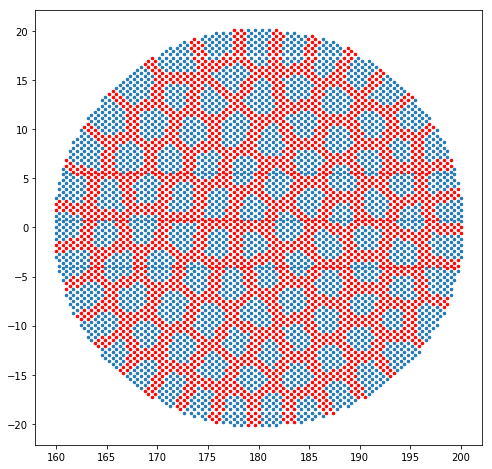

In [3]:
pix_id = hp.pixelfunc.ang2pix(NSIDE, hp_ra, hp_dec, lonlat=True)

neighbors = hp.get_all_neighbours(NSIDE, hp_ra, hp_dec, lonlat=True).T
mask = np.in1d(neighbors, pix_id).reshape(neighbors.shape)
neighbors[~mask] = -1

# Convert to native numpy indices of the pixels
# pointer from healpy indices to pixel indices:
pointer = -99 * np.ones(npix, dtype=int)
for index in range(len(hp_ra)):
    pointer[pix_id[index]] = index
neighbors[mask] = pointer[neighbors[mask]]

# Find bordering pixels
mask1 = labels[neighbors] != labels[:, None]
mask2 = neighbors>=0
mask_border = np.any(mask1 & mask2, axis=1)
print(np.sum(mask_border), 'bordering pixels')
plt.figure(figsize=(8, 8))
plt.plot(hp_ra[~mask_border], hp_dec[~mask_border], '.', markersize=5)
plt.plot(hp_ra[mask_border], hp_dec[mask_border], 'r.', markersize=5)
plt.show()

In [4]:
# Default parameters:
default_params = {
    'mutate_rate': 0.001,
    'ngen': 50000,  # number of generations to run
    'equality_weight': 1.2, # weight of imposing equal weighted pix counts in fitness function
    'spherical': True, 
}

ngroup = len(np.unique(labels))

In [5]:
import pixel_partition_greedy
# reload(optimized_pixel_partition_greedy)

# Initialize
optimizer = pixel_partition_greedy.Subsampler(hp_ra, hp_dec, ngroup, neighbors, weights=counts, **default_params)

-----------
__Evolve!__

In [6]:
# np.random.seed(2)

# fitness scores of the initial configuration
score, compactness, equality, w_counts = optimizer.fitness(labels)

############################## Evolve! ##############################
time_start = time.time()
for idx_gen in range(default_params['ngen']):
    
    # mutate
    labels_new = optimizer.mutate(labels)
    score_temp, compactness_temp, equality_temp, w_counts_temp = optimizer.fitness(labels_new)
    
    if score_temp > score:
        labels = labels_new
        score, compactness, equality, w_counts = \
        score_temp, compactness_temp, equality_temp, w_counts_temp
    
    if idx_gen%1000==0:
        print('{:9d} {:14.5g} {:14.5g} {:14.5g}'.\
              format(idx_gen, score, compactness, equality))

print(time.strftime("%H:%M:%S", time.gmtime(time.time() - time_start)))

        0        -2.7715          2.523        0.24853
     1000        -2.7677         2.5302        0.23754
     2000        -2.7598         2.5336         0.2262
     3000        -2.7516         2.5377        0.21384
     4000        -2.7428         2.5407        0.20209
     5000        -2.7329         2.5421        0.19078
     6000        -2.7253         2.5446        0.18065
     7000        -2.7172         2.5456        0.17162
     8000        -2.7076         2.5456        0.16204
     9000        -2.6991         2.5467        0.15235
    10000        -2.6902         2.5474        0.14287
    11000        -2.6824         2.5489        0.13349
    12000        -2.6769         2.5471        0.12982
    13000        -2.6697         2.5465        0.12319
    14000        -2.6607         2.5449        0.11572
    15000        -2.6541         2.5438        0.11027
    16000        -2.6479         2.5444        0.10348
    17000         -2.641         2.5467       0.094337
    18000 

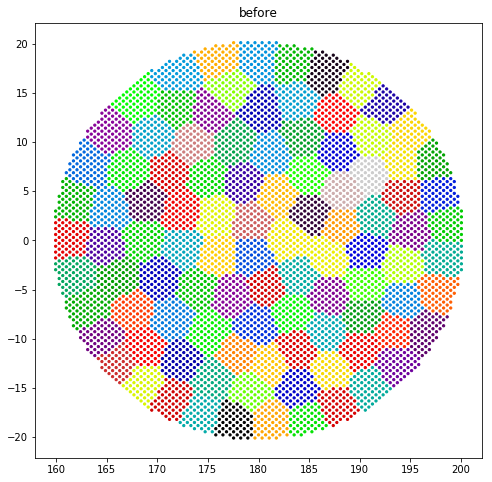

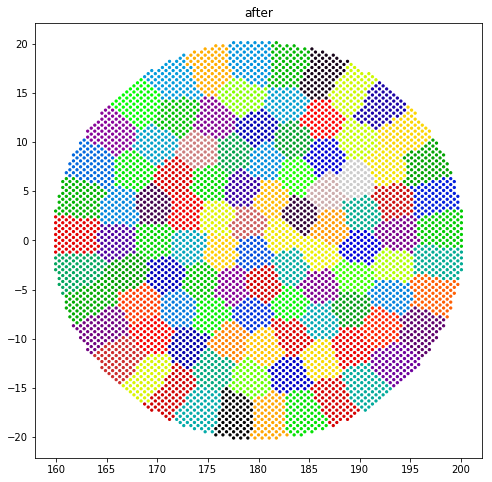

In [7]:
plt.rcParams['image.cmap'] = 'jet'

# Original grouping
plt.figure(figsize=(8, 8))
plt.scatter(hp_ra, hp_dec, c=labels_original, s=5, cmap=plt.cm.nipy_spectral)
plt.title('before')
plt.show()

# Final grouping
plt.figure(figsize=(8, 8))
plt.scatter(hp_ra, hp_dec, c=labels, s=5, cmap=plt.cm.nipy_spectral)
plt.title('after')
plt.show()

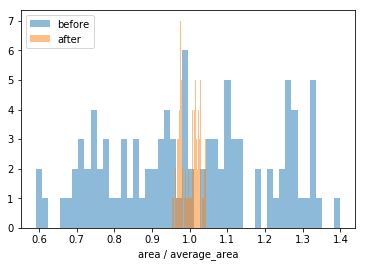

In [8]:
group_counts_original = np.zeros(ngroup)
for idx_grp in range(ngroup):
    members = np.where(labels_original==idx_grp)[0]
    group_counts_original[idx_grp] = np.sum(counts[members])

plt.hist(group_counts_original/optimizer.average_count, 50, alpha=0.5, label='before')
plt.hist(w_counts/optimizer.average_count, 50, alpha=0.5, label='after')
plt.legend(loc='upper left')
plt.xlabel('area / average_area')
plt.show()

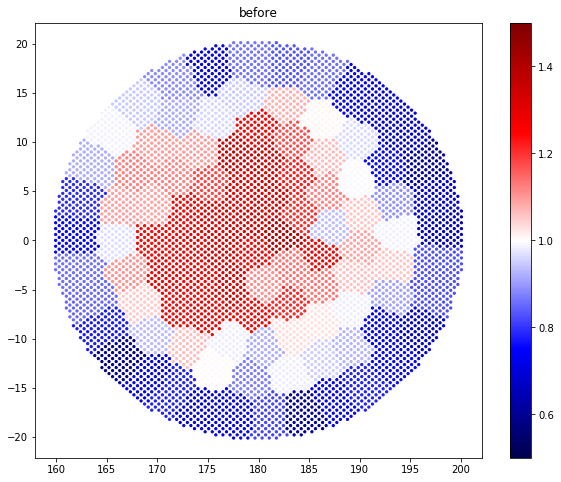

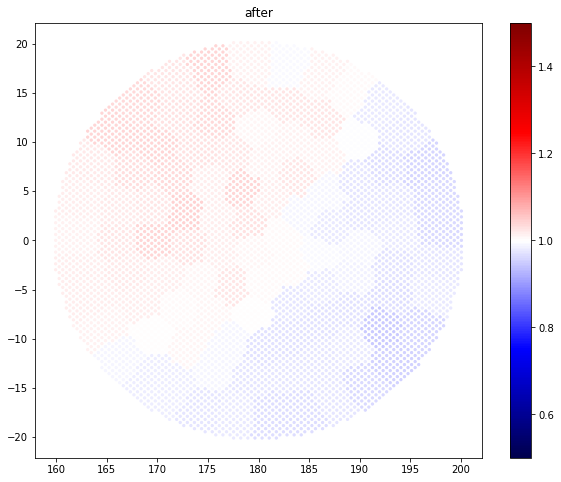

In [9]:
# Plot fractional under/over-density

counts_pix_original = group_counts_original[labels]
plt.figure(figsize=(10, 8))
plt.scatter(hp_ra, hp_dec, c=counts_pix_original/optimizer.average_count,
            cmap=plt.cm.seismic, s=5, vmin=0.5, vmax=1.5)
plt.colorbar()
plt.title('before')
plt.show()

counts_pix = w_counts[labels]
plt.figure(figsize=(10, 8))
plt.scatter(hp_ra, hp_dec, c=counts_pix/optimizer.average_count,
            cmap=plt.cm.seismic, s=5, vmin=0.5, vmax=1.5)
plt.colorbar()
plt.title('after')
plt.show()